In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import RobustScaler

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

Load data

In [2]:
df = pd.read_csv('/kaggle/input/student-stress-monitoring-datasets/StressLevelDataset.csv')
df.head(10)

,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,...,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
0,14,20,0,11,2,1,2,4,2,3,...,2,3,2,3,3,2,3,3,2,1
1,15,8,1,15,5,3,1,4,3,1,...,2,1,4,1,5,1,4,5,5,2
2,12,18,1,14,2,1,2,2,2,2,...,2,2,3,3,2,2,3,2,2,1
3,16,12,1,15,4,3,1,3,4,2,...,2,2,4,1,4,1,4,4,5,2
4,16,28,0,7,2,3,5,1,3,2,...,3,4,3,1,2,1,5,0,5,1
5,20,13,1,21,3,3,1,4,3,2,...,1,2,5,2,5,1,4,4,5,2
6,4,26,0,6,1,2,4,1,1,4,...,4,5,1,4,1,3,2,2,1,0
7,17,3,1,22,4,3,1,5,3,1,...,1,1,3,2,4,1,4,4,5,2
8,13,22,1,12,3,1,2,4,3,3,...,3,3,3,2,3,3,3,2,2,1
9,6,8,0,27,4,3,1,2,0,5,...,2,2,2,1,5,1,5,3,4,1


Description

In [3]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   anxiety_level                 1100 non-null   int64
 1   self_esteem                   1100 non-null   int64
 2   mental_health_history         1100 non-null   int64
 3   depression                    1100 non-null   int64
 4   headache                      1100 non-null   int64
 5   blood_pressure                1100 non-null   int64
 6   sleep_quality                 1100 non-null   int64
 7   breathing_problem             1100 non-null   int64
 8   noise_level                   1100 non-null   int64
 9   living_conditions             1100 non-null   int64
 10  safety                        1100 non-null   int64
 11  basic_needs                   1100 non-null   int64
 12  academic_performance          1100 non-null   int64
 13  study_load                    110

Bar plot stress level and anxiety level

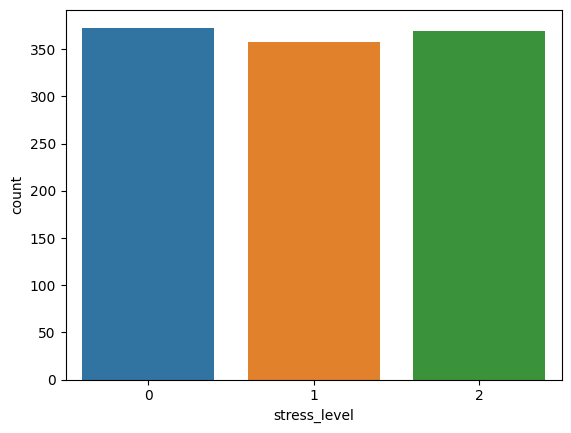

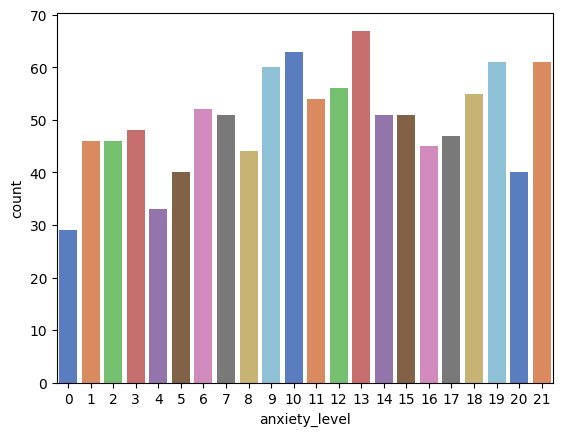

In [4]:
sns.countplot(df, x = "stress_level")
plt.show()
sns.countplot(df, x = "anxiety_level", palette = "muted")
plt.show()

### Depression vs. Anxiety Levels Stratified by Mental Health History and Stress Level

This faceted scatterplot visualization examines the relationship between **depression scores** (x-axis) and **anxiety levels** (y-axis) across different subgroups defined by:
1. **Mental Health History** (columns):
   - `0`: No prior mental health conditions
   - `1`: History of mental health conditions
   
2. **Current Stress Level** (rows):
   - `0`: Low stress
   - `1`: Moderate stress
   - `2`: High stress

#### Key Observations:
1. **Positive Correlation Trend**:
   - Across all subgroups, higher depression scores generally correspond to higher anxiety levels (diagonal clustering pattern)
   - The strongest correlation appears in individuals with prior mental health conditions (right column)

2. **Mental Health History Impact**:
   - Individuals with mental health history (right column) show:
     - Wider spread of depression/anxiety scores
     - Higher concentration of extreme values (top-right quadrant)
   - Those without history (left column) cluster in lower ranges

3. **Stress Level Moderation**:
   - High-stress individuals (bottom row) show:
     - Elevated anxiety levels even at moderate depression scores
     - Less separation between mental health history groups
   - Low-stress individuals (top row) maintain tighter clustering

4. **Critical Risk Group**:
   - The high-stress + mental health history quadrant (bottom-right) contains:
     - Highest density of severe cases (depression > 7, anxiety > 8)
     - Potential priority group for interventions

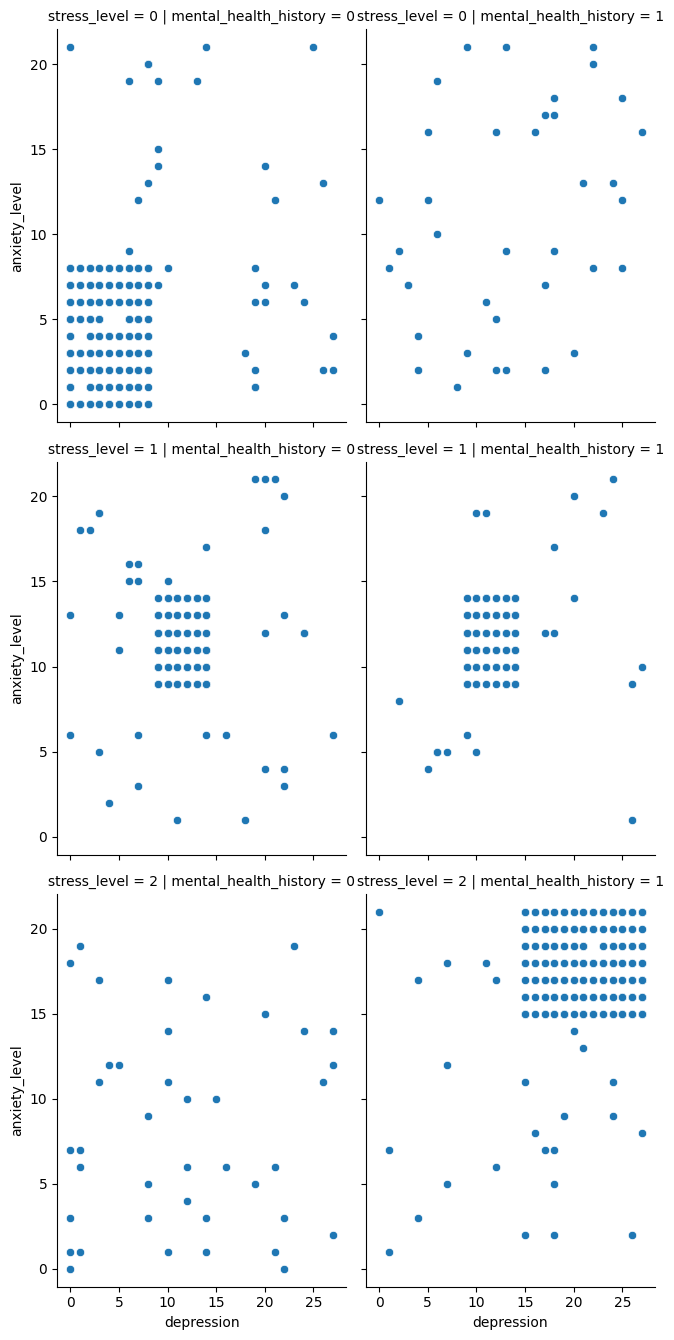

In [5]:
stress_mental = sns.FacetGrid(df, col="mental_health_history", row="stress_level", height=4.5, aspect=.75)
stress_mental.map(sns.scatterplot, "depression", "anxiety_level")

## Feature Engineering: Creating Composite Mental Health Indicators

### Rationale
We engineered two novel features to capture **synergistic risk factors**
1. **`anxiety_bullying`**: Quantifies compounded psychological distress from:
   - `anxiety_level`: Baseline anxiety symptoms
   - `bullying`: Exposure to victimization
   - Modulated by inverse `teacher_student_relationship` quality (5 = best)

   **Formula**:  
   `(anxiety_level × bullying) × (5 - teacher_student_relationship)`  
   - Higher values indicate: *Anxious students experiencing bullying with poor teacher support*

2. **`anxiety_depression`**: Measures comorbidity severity of:
   - `anxiety_level` and `depression` symptoms
   - Amplified by low `social_support` (5 = strongest support)

   **Formula**:  
   `(anxiety_level × depression) × (5 - social_support)`  
   - Higher values indicate: *Co-occurring anxiety-depression with inadequate social buffers*

In [6]:
features = df.columns.drop('stress_level')

df['teacher_student_relationship'] = df['teacher_student_relationship'].replace(0, 1e-6)
df['social_support'] = df['social_support'].replace(0, 1e-6)

df["anxiety_bullying"] = (df["anxiety_level"] * df["bullying"]) * (5 - df["teacher_student_relationship"])
df["anxiety_depression"] = (df["anxiety_level"] * df["depression"]) * (5 - df["social_support"])

x = df[features]
y = df['stress_level']


## Model Training Pipeline: Implementation and Rationale

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)


rf_model = RandomForestClassifier(random_state=42)
svm_model = SVC(random_state=42, max_iter=1000)
lr_model = LogisticRegression(random_state=42, max_iter=1000)

models = {'Random Forest': rf_model, 'SVM': svm_model, 'Logistic Regression': lr_model}
results = {}

scaler = RobustScaler()
X_train_scaledd = scaler.fit_transform(X_train)
X_test_scaledd = scaler.transform(X_test)

metrics_results = []



Random Forest Accuracy: 0.8682
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        76
           1       0.89      0.86      0.88        73
           2       0.88      0.86      0.87        71

    accuracy                           0.87       220
   macro avg       0.87      0.87      0.87       220
weighted avg       0.87      0.87      0.87       220





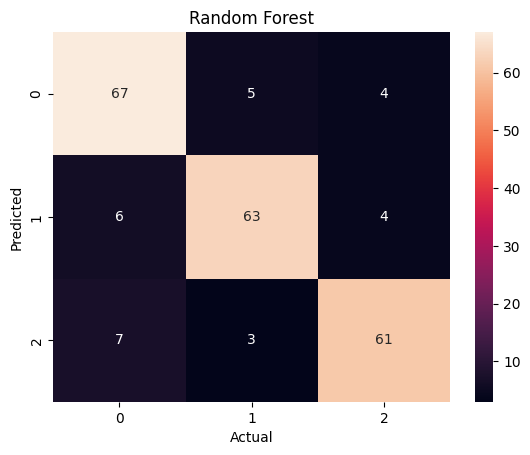

SVM Accuracy: 0.8545
              precision    recall  f1-score   support

           0       0.78      0.87      0.82        76
           1       0.95      0.84      0.89        73
           2       0.86      0.86      0.86        71

    accuracy                           0.85       220
   macro avg       0.86      0.85      0.86       220
weighted avg       0.86      0.85      0.86       220





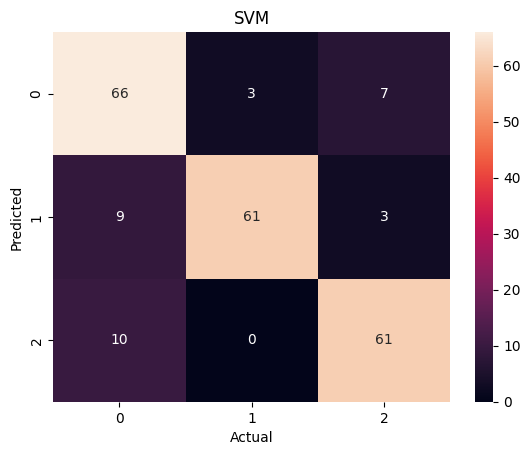

Logistic Regression Accuracy: 0.8864
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        76
           1       0.88      0.89      0.88        73
           2       0.90      0.92      0.91        71

    accuracy                           0.89       220
   macro avg       0.89      0.89      0.89       220
weighted avg       0.89      0.89      0.89       220





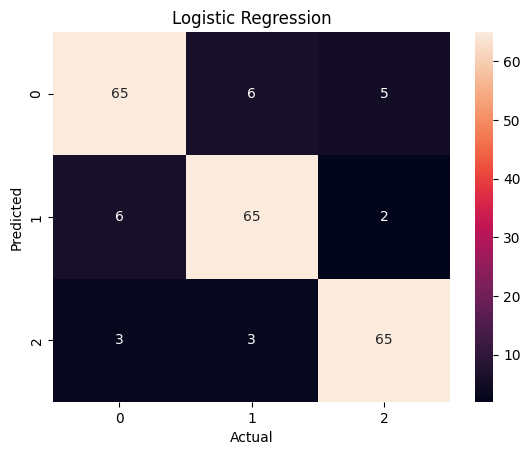

Best model: Logistic Regression | Accuracy:  0.8863636363636364


In [8]:
for name, model in models.items():
    iter = 0
    model.fit(X_train_scaledd, Y_train)
    y_pred = model.predict(X_test_scaledd)
    accuracy = accuracy_score(Y_test, y_pred)

    report_dict = classification_report(Y_test, y_pred, output_dict=True)

    metrics_results.append({
        'model_name' : name,
        'accuracy' : accuracy,
        'classification_report' : report_dict,
        'full_report': classification_report(Y_test, y_pred)
    })

    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(Y_test, y_pred))
    print("\n" + "="*50 + "\n")
    

    cm= metrics.confusion_matrix(Y_test, y_pred)
    sns.heatmap(cm, annot= True)
    plt.title(name)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()
    iter += 1                                               

# Evaluate the model
accuracy = accuracy_score(Y_test, y_pred)
best_model = max(metrics_results, key=lambda x: x['accuracy'])
print(f"Best model: {best_model['model_name']} | Accuracy:  {best_model['accuracy']}")